# NYC Air Quality & Public Health Correlation

#### 6513-C Big Data FA25

Stephanie Pavon (sp8089)

Xavier Beltran (xb2101)

Philip Vetsas (pmv264)

Dongting Gao (dg4528)

## **Setups and imports**

### **Download all both datasets, put the largest dataset (Hospital dataset into a Google Drive folder called "BigData_Project") for this to work**

In [51]:
import pandas as pd
import numpy as np
import os, shutil

try: 
    # if running in Google Colab
    from google.colab import drive, files
    drive.mount('/content/drive') # needed for hospital dataset
    path = '/content/drive/MyDrive/BigData_Project'
except:
    # if running locally
    path = os.getcwd()

print("Libraries imported.")

resources_path = os.path.join(path, 'resources')
# output dir for visualizations
output_path = os.path.join(path, "output")
os.makedirs(output_path, exist_ok=True)
print("Using resources from:", resources_path)

Libraries imported.
Using resources from: /home/philip/uni/big_data/BigDataProject/resources


## **Uploading Air Quality Dataset**

---



In [52]:
filename = "Air_Quality_20251201.csv"
filepath = os.path.join(resources_path, filename)

if os.path.exists(filepath):
    if not os.path.exists(filename):
        shutil.copy(filepath, filename)
    with open(filepath, "rb") as f:
        air_quality_file = {filename: f.read()}
    print(f"Using {filename} from {path}")
else:
    try:
        print(f"{filename} not found in {path}. Please upload the Air Quality CSV:")
        air_quality_file = files.upload()
    except NameError:
        raise RuntimeError(
            "files.upload() is not available in this environment. "
            "Place the CSV in the working directory or update `path` to where the file resides."
        )

Using Air_Quality_20251201.csv from /home/philip/uni/big_data/BigDataProject


## **Loading dataset**

In [53]:
air_df = pd.read_csv(list(air_quality_file.keys())[0])
print(air_df.columns)
air_df.head()


Index(['Unique ID', 'Indicator ID', 'Name', 'Measure', 'Measure Info',
       'Geo Type Name', 'Geo Join ID', 'Geo Place Name', 'Time Period',
       'Start_Date', 'Data Value', 'Message'],
      dtype='object')


,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,878218,386,Ozone (O3),Mean,ppb,UHF42,402,West Queens,Summer 2023,06/01/2023,34.365989,NaN
1,876975,375,Nitrogen dioxide (NO2),Mean,ppb,UHF42,501,Port Richmond,Summer 2023,06/01/2023,11.331992,NaN
2,876900,375,Nitrogen dioxide (NO2),Mean,ppb,UHF42,207,East Flatbush - Flatbush,Summer 2023,06/01/2023,12.020333,NaN
3,877140,375,Nitrogen dioxide (NO2),Mean,ppb,CD,205,Fordham and University Heights (CD5),Summer 2023,06/01/2023,14.123178,NaN
4,874556,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF34,410,Rockaways,Summer 2023,06/01/2023,8.150637,NaN


## **Cleaning Air Quality Dataset**

In [54]:
# Drop duplicates
air_df = air_df.drop_duplicates()

# Keep only UHF42 rows
air_df = air_df[air_df["Geo Type Name"] == "UHF42"]

# Keep NO2 and O3 only
pollutant_names = ["Nitrogen dioxide (NO2)", "Ozone (O3)"]
air_df = air_df[air_df["Name"].isin(pollutant_names)]

#get latest per pollutant
latest_per_pollutant = (
    air_df.groupby("Name")["Time Period"].transform("max")
)

air_df = air_df[ air_df["Time Period"] == latest_per_pollutant ]

# Cleaner pollutant labels
air_df["Pollutant"] = air_df["Name"].replace({
    "Nitrogen dioxide (NO2)": "NO2",
    "Ozone (O3)": "O3"
})

# Pivot to wide format
air_wide = air_df.pivot_table(
    index=["Geo Place Name", "Geo Join ID"],
    columns="Pollutant",
    values="Data Value"
).reset_index()

air_wide.head()


Pollutant,Geo Place Name,Geo Join ID,NO2,O3
0,Bayside - Little Neck,404,17.441851,36.889532
1,Bedford Stuyvesant - Crown Heights,203,23.313894,36.158125
2,Bensonhurst - Bay Ridge,209,21.599357,37.300851
3,Borough Park,206,22.318317,37.403605
4,Canarsie - Flatlands,208,19.464378,38.295018


## **Cleaning Population Dataset**

In [55]:
from io import StringIO

population = """
UHF42,Geo Place Name,Population
101,Kingsbridge - Riverdale,118388
102,Northeast Bronx,155442
103,Fordham - Bronx Park,174742
104,Pelham - Throgs Neck,140169
105,Crotona - Tremont,165527
106,High Bridge - Morrisania,151274
107,Hunts Point - Mott Haven,114963
201,Greenpoint,106768
202,Downtown - Heights - Park Slope,238815
203,Bedford Stuyvesant - Crown Heights,246687
204,East New York, 182896
205,Sunset Park,150744
206,Borough Park,202759
207,East Flatbush - Flatbush,226886
208,Canarsie - Flatlands,192192
209,Bensonhurst - Bay Ridge,199556
210,Coney Island - Sheepshead Bay,171975
211,Williamsburg - Bushwick,195818
301,Washington Heights - Inwood,206451
302,Central Harlem - Morningside Heights,125088
303,East Harlem,123905
304,Upper West Side,211197
305,Upper East Side,219814
306,Chelsea - Clinton,127452
307,Gramercy Park - Murray Hill,161396
308,Greenwich Village - Soho,114219
309,Union Square - Lower East Side,188564
310,Lower Manhattan,58004
401,Long Island City - Astoria,163748
402,West Queens,205123
403,Flushing - Clearview,187108
404,Bayside-Little Neck,172214
405,Ridgewood - Forest Hills,237757
406,Fresh Meadows,194105
407,Southwest Queens,269260
408,Jamaica,223353
409,Southeast Queens,196482
410,Rockaway,123800
501,Port Richmond,82159
502,Stapleton - St.George,129153
503,Willowbrook,89134
504,South Beach - Tottenville,101379

"""

pop_cleaned = pd.read_csv(StringIO(population))
pop_cleaned.head()


,UHF42,Geo Place Name,Population
0,101,Kingsbridge - Riverdale,118388
1,102,Northeast Bronx,155442
2,103,Fordham - Bronx Park,174742
3,104,Pelham - Throgs Neck,140169
4,105,Crotona - Tremont,165527


In [56]:
# Merge air quality (O3 + NO2) with population by UHF42
final_df = air_wide.merge(
    pop_cleaned,
    left_on="Geo Join ID",
    right_on="UHF42",
    how="left"
)

# Drop duplicate Geo Place column if exists
if "Geo Place Name_y" in final_df.columns:
    final_df = final_df.rename(columns={
        "Geo Place Name_x": "Geo Place Name"
    })
    final_df = final_df.drop(columns=["Geo Place Name_y"])

final_df.head()


,Geo Place Name,Geo Join ID,NO2,O3,UHF42,Population
0,Bayside - Little Neck,404,17.441851,36.889532,404,172214
1,Bedford Stuyvesant - Crown Heights,203,23.313894,36.158125,203,246687
2,Bensonhurst - Bay Ridge,209,21.599357,37.300851,209,199556
3,Borough Park,206,22.318317,37.403605,206,202759
4,Canarsie - Flatlands,208,19.464378,38.295018,208,192192


## **Installing and Starting up PySpark**

In [57]:
%pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("NYC_AirQuality_Project") \
    .getOrCreate()

print("Spark Session created.")


Note: you may need to restart the kernel to use updated packages.
Spark Session created.


## **Uploading SPARCS Hospital Dataset**

In [58]:
# Path to your FULL raw SPARCS dataset
hs = "Hospital_Inpatient_Discharges_2016.csv"
file_path = os.path.join(resources_path, hs)

# Load the BIG dataset using Spark
hospital_df = spark.read.csv(file_path, header=True, inferSchema=True)
print("Schema loaded:")
hospital_df.printSchema()

Schema loaded:
root
 |-- Health Service Area: string (nullable = true)
 |-- Hospital County: string (nullable = true)
 |-- Operating Certificate Number: integer (nullable = true)
 |-- Facility Id: string (nullable = true)
 |-- Facility Name: string (nullable = true)
 |-- Age Group: string (nullable = true)
 |-- Zip Code - 3 digits: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Length of Stay: string (nullable = true)
 |-- Type of Admission: string (nullable = true)
 |-- Patient Disposition: string (nullable = true)
 |-- Discharge Year: integer (nullable = true)
 |-- CCS Diagnosis Code: integer (nullable = true)
 |-- CCS Diagnosis Description: string (nullable = true)
 |-- CCS Procedure Code: integer (nullable = true)
 |-- CCS Procedure Description: string (nullable = true)
 |-- APR DRG Code: integer (nullable = true)
 |-- APR DRG Description: string (nullable = true)
 |-- APR MDC Code: in

In [59]:
hospital_df.show(5)

+-------------------+---------------+----------------------------+-----------+--------------------+-----------+-------------------+------+-----+-----------------+--------------+-----------------+-------------------+--------------+------------------+-------------------------+------------------+-------------------------+------------+--------------------+------------+--------------------+----------------------------+-----------------------------------+---------------------+--------------------------------+--------------------+--------------------+------------------+------------+-----------------------+------------------------------+-------------+-----------+
|Health Service Area|Hospital County|Operating Certificate Number|Facility Id|       Facility Name|  Age Group|Zip Code - 3 digits|Gender| Race|        Ethnicity|Length of Stay|Type of Admission|Patient Disposition|Discharge Year|CCS Diagnosis Code|CCS Diagnosis Description|CCS Procedure Code|CCS Procedure Description|APR DRG Code| AP

## **Filtering Asthma Cases**

In [60]:
# 4. Filter asthma cases (CCS Code 128)
asthma_df = hospital_df.filter(
    (hospital_df["CCS Diagnosis Code"] == 128) |
    (hospital_df["CCS Diagnosis Description"] == "Asthma")
)

print("Asthma cases sample:")
asthma_df.show(10)

print("Total asthma cases:", asthma_df.count())



Asthma cases sample:
+-------------------+---------------+----------------------------+-----------+--------------------+-----------+-------------------+------+-----+-----------------+--------------+-----------------+--------------------+--------------+------------------+-------------------------+------------------+-------------------------+------------+-------------------+------------+--------------------+----------------------------+-----------------------------------+---------------------+--------------------------------+--------------------+--------------------+------------------+------------+-----------------------+------------------------------+-------------+-----------+
|Health Service Area|Hospital County|Operating Certificate Number|Facility Id|       Facility Name|  Age Group|Zip Code - 3 digits|Gender| Race|        Ethnicity|Length of Stay|Type of Admission| Patient Disposition|Discharge Year|CCS Diagnosis Code|CCS Diagnosis Description|CCS Procedure Code|CCS Procedure Descri

Total asthma cases: 21565


## **Grouping by Zipcode**

In [61]:
from pyspark.sql.functions import substring, col

# 1. Extract ZIP3 prefixes from "Zip Code - 3 digits"
asthma_df = asthma_df.withColumn("zip3", substring("Zip Code - 3 digits", 1, 3))

# 2. Get ALL distinct ZIP3 prefixes found in your SPARCS asthma data
zip3_list = [row["zip3"] for row in asthma_df.select("zip3").distinct().collect()]

print("All ZIP3 prefixes found in SPARCS:")
print(zip3_list)

# 3. Filter ZIP3 to only NYC ZIP prefixes (100–116 range)
nyc_zip3 = [
    "100", "101", "102",   # Manhattan
    "103",                 # Staten Island
    "104",                 # The Bronx
    "112",                 # Brooklyn
    "110", "111", "113", "114", "116"   # Queens
]

print("NYC ZIP3 prefixes detected:")
print(nyc_zip3)


# 4. Filter asthma rows to ALL detected NYC ZIP3 (expanded coverage!)
asthma_nyc_df = asthma_df.filter(col("zip3").isin(nyc_zip3))

print("NYC-only asthma case count:", asthma_nyc_df.count())

# 5. Group asthma counts by ZIP3 (THIS WILL PRODUCE MORE ZIP3 THAN BEFORE!)
asthma_counts = asthma_nyc_df.groupBy("zip3").count() \
                             .withColumnRenamed("count", "Asthma_Count")

asthma_counts.show(50)




All ZIP3 prefixes found in SPARCS:
['140', '147', 'OOS', '144', '148', '141', '143', '142', '145', '146', '131', '130', '117', '149', '132', '138', '133', '139', '136', '135', '134', '121', '137', '125', '124', '120', '128', '122', '123', '129', '112', '126', '104', '127', '109', '107', '100', '108', '106', '105', '119', '101', '113', '110', '111', '114', '116', '103', '115', '118', None]
NYC ZIP3 prefixes detected:
['100', '101', '102', '103', '104', '112', '110', '111', '113', '114', '116']


NYC-only asthma case count: 14344
+----+------------+
|zip3|Asthma_Count|
+----+------------+
| 112|        3658|
| 104|        5708|
| 100|        1843|
| 101|          34|
| 113|         936|
| 110|         167|
| 111|         155|
| 114|        1088|
| 116|         141|
| 103|         614|
+----+------------+



In [62]:
# Convert Spark asthma counts → pandas for merging
asthma_pd = asthma_counts.toPandas()
asthma_pd


,zip3,Asthma_Count
0,112,3658
1,104,5708
2,100,1843
3,101,34
4,113,936
5,110,167
6,111,155
7,114,1088
8,116,141
9,103,614


In [63]:
zip_to_uhf_csv = """
zip3,UHF42
100,304
101,305
102,310
103,503
104,105
110,409
111,401
112,203
113,403
114,407
116,410
"""

zip_map = pd.read_csv(StringIO(zip_to_uhf_csv))
zip_map


,zip3,UHF42
0,100,304
1,101,305
2,102,310
3,103,503
4,104,105
5,110,409
6,111,401
7,112,203
8,113,403
9,114,407


In [64]:
# Ensure zip3 is a string
asthma_pd["zip3"] = asthma_pd["zip3"].astype(str)
zip_map["zip3"] = zip_map["zip3"].astype(str)

# Merge asthma ZIP3 → UHF42
asthma_uhf = asthma_pd.merge(
    zip_map,
    on="zip3",
    how="left"
)

asthma_uhf



,zip3,Asthma_Count,UHF42
0,112,3658,203
1,104,5708,105
2,100,1843,304
3,101,34,305
4,113,936,403
5,110,167,409
6,111,155,401
7,114,1088,407
8,116,141,410
9,103,614,503


In [65]:
asthma_by_uhf = asthma_uhf.groupby("UHF42")["Asthma_Count"].sum().reset_index()
asthma_by_uhf


,UHF42,Asthma_Count
0,105,5708
1,203,3658
2,304,1843
3,305,34
4,401,155
5,403,936
6,407,1088
7,409,167
8,410,141
9,503,614


In [66]:
# Final merge: attach asthma counts to the UHF42 air-quality table

final_with_asthma = final_df.merge(
    asthma_by_uhf,
    on="UHF42",
    how="left"
)

final_with_asthma.head()

,Geo Place Name,Geo Join ID,NO2,O3,UHF42,Population,Asthma_Count
0,Bayside - Little Neck,404,17.441851,36.889532,404,172214,NaN
1,Bedford Stuyvesant - Crown Heights,203,23.313894,36.158125,203,246687,3658.0
2,Bensonhurst - Bay Ridge,209,21.599357,37.300851,209,199556,NaN
3,Borough Park,206,22.318317,37.403605,206,202759,NaN
4,Canarsie - Flatlands,208,19.464378,38.295018,208,192192,NaN


## **Exporting Results to CSV**


In [67]:
# Export final dataset to CSV
output = "final_dataset.csv"
csv_path = os.path.join(output_path, output)
final_with_asthma.to_csv(csv_path, index=False)

print("Exported to:", csv_path)


Exported to: /home/philip/uni/big_data/BigDataProject/output/final_dataset.csv


In [68]:
# pmv264 - I'm using this to run testing and get my code set up in an 
# external notebook before bringing it over here
# we can  delete this later

import pickle

to_pickle = []

to_pickle.append(("asthma_pd", asthma_pd))

# final_df
to_pickle.append(("final_df", final_df))

for name, obj in to_pickle:
    out_path = os.path.join(resources_path, f"{name}.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(obj, f)
    print(f"Saved {name} -> {out_path}")

Saved asthma_pd -> /home/philip/uni/big_data/BigDataProject/resources/asthma_pd.pkl
Saved final_df -> /home/philip/uni/big_data/BigDataProject/resources/final_df.pkl


## **Asthma hospitalization records in the SPARCS dataset are reported using ZIP3 codes. ZIP3 boundaries do not align perfectly with UHF42 neighborhoods, so asthma counts assigned to each UHF42 should be interpreted as approximate estimates rather than exact results.**





# Data Integration, Analysis & Visualization

In [69]:
final_with_asthma.head()

,Geo Place Name,Geo Join ID,NO2,O3,UHF42,Population,Asthma_Count
0,Bayside - Little Neck,404,17.441851,36.889532,404,172214,NaN
1,Bedford Stuyvesant - Crown Heights,203,23.313894,36.158125,203,246687,3658.0
2,Bensonhurst - Bay Ridge,209,21.599357,37.300851,209,199556,NaN
3,Borough Park,206,22.318317,37.403605,206,202759,NaN
4,Canarsie - Flatlands,208,19.464378,38.295018,208,192192,NaN


# Compute Asthma Rate

In [70]:
df = final_with_asthma.copy()

# Replace NaN asthma_count with 0 (areas with no hospital cases)
df["Asthma_Count"] = df["Asthma_Count"].fillna(0)

df["asthma_rate"] = df["Asthma_Count"] / df["Population"] * 10000

df.head()

,Geo Place Name,Geo Join ID,NO2,O3,UHF42,Population,Asthma_Count,asthma_rate
0,Bayside - Little Neck,404,17.441851,36.889532,404,172214,0.0,0.000000
1,Bedford Stuyvesant - Crown Heights,203,23.313894,36.158125,203,246687,3658.0,148.285074
2,Bensonhurst - Bay Ridge,209,21.599357,37.300851,209,199556,0.0,0.000000
3,Borough Park,206,22.318317,37.403605,206,202759,0.0,0.000000
4,Canarsie - Flatlands,208,19.464378,38.295018,208,192192,0.0,0.000000


# Borough summaries

pmv264 - I changed this because the UHF code values did not match the 'Geo place name' values already existing in the df, nor the UHF code translations I found online. This is the source I used.

https://www.nyc.gov/assets/doh/downloads/pdf/ah/zipcodetable.pdf

In [71]:
def get_borough(uhf):
    if 101 <= uhf <= 107:
        return "Bronx"
    elif 201 <= uhf <= 212:
        return "Brooklyn"
    elif 301 <= uhf <= 314:
        return "Manhattan"
    elif 401 <= uhf <= 410:
        return "Queens"
    elif 501 <= uhf <= 514:
        return "Staten Island"
    else:
        return "Unknown"

df["Borough"] = df["UHF42"].apply(get_borough)
df.head()

,Geo Place Name,Geo Join ID,NO2,O3,UHF42,Population,Asthma_Count,asthma_rate,Borough
0,Bayside - Little Neck,404,17.441851,36.889532,404,172214,0.0,0.000000,Queens
1,Bedford Stuyvesant - Crown Heights,203,23.313894,36.158125,203,246687,3658.0,148.285074,Brooklyn
2,Bensonhurst - Bay Ridge,209,21.599357,37.300851,209,199556,0.0,0.000000,Brooklyn
3,Borough Park,206,22.318317,37.403605,206,202759,0.0,0.000000,Brooklyn
4,Canarsie - Flatlands,208,19.464378,38.295018,208,192192,0.0,0.000000,Brooklyn


In [72]:
borough_summary = (
    df[df["Borough"] != "Unknown"]
      .groupby("Borough")
      .agg({
          "NO2": "mean",
          "O3": "mean",
          "asthma_rate": "mean",
          "Population": "sum",
          "Asthma_Count": "sum"
      })
      .reset_index()
)

borough_summary

,Borough,NO2,O3,asthma_rate,Population,Asthma_Count
0,Bronx,19.936941,32.569725,49.262572,1020505,5708.0
1,Brooklyn,22.335567,36.434559,13.480461,2115096,3658.0
2,Manhattan,22.715505,30.223222,8.881126,1536090,1877.0
3,Queens,19.223091,37.020927,11.978623,1972950,2487.0
4,Staten Island,18.179655,34.270028,17.221262,401825,614.0


# Neighborhood Comparisons

In [73]:
neighborhood_asthma = df.sort_values("asthma_rate", ascending=False)
neighborhood_asthma.head(10)

,Geo Place Name,Geo Join ID,NO2,O3,UHF42,Population,Asthma_Count,asthma_rate,Borough
8,Crotona -Tremont,105,21.974062,32.150245,105,165527,5708.0,344.838002,Bronx
1,Bedford Stuyvesant - Crown Heights,203,23.313894,36.158125,203,246687,3658.0,148.285074,Brooklyn
37,Upper West Side,304,21.435208,29.759108,304,211197,1843.0,87.264497,Manhattan
41,Willowbrook,503,17.202216,34.652718,503,89134,614.0,68.885049,Staten Island
13,Flushing - Clearview,403,18.932675,36.689503,403,187108,936.0,50.024585,Queens
32,Southwest Queens,407,20.649382,37.447052,407,269260,1088.0,40.407042,Queens
29,Rockaways,410,11.901923,43.332874,410,123800,141.0,11.389338,Queens
23,Long Island City - Astoria,401,22.303082,33.216065,401,163748,155.0,9.465764,Queens
31,Southeast Queens,409,17.649727,38.182015,409,196482,167.0,8.499506,Queens
36,Upper East Side,305,22.321758,31.244535,305,219814,34.0,1.546762,Manhattan


In [74]:
neighborhood_no2 = df.sort_values("NO2", ascending=False).head(10)
neighborhood_o3  = df.sort_values("O3", ascending=False).head(10)

neighborhood_no2, neighborhood_o3

(                        Geo Place Name  Geo Join ID        NO2         O3  \
 6                    Chelsea - Clinton          306  25.832804  28.353175   
 16         Gramercy Park - Murray Hill          307  25.774295  29.472850   
 34                         Sunset Park          205  24.342430  34.509679   
 18            Greenwich Village - SoHo          308  24.186537  29.056301   
 24                     Lower Manhattan          310  24.030653  29.888232   
 40             Williamsburg - Bushwick          211  23.810742  35.499418   
 17                          Greenpoint          201  23.781264  33.754222   
 9           Downtown - Heights - Slope          202  23.551557  33.868690   
 1   Bedford Stuyvesant - Crown Heights          203  23.313894  36.158125   
 12                       East New York          204  22.845627  36.314509   
 
     UHF42  Population  Asthma_Count  asthma_rate    Borough  
 6     306      127452           0.0     0.000000  Manhattan  
 16    307    

In [75]:
neighborhood_summary = df[[
    "Geo Place Name",
    "Borough",
    "NO2",
    "O3",
    "asthma_rate",
    "Population",
    "Asthma_Count"
]].sort_values("asthma_rate", ascending=False)

neighborhood_summary.head(10)

,Geo Place Name,Borough,NO2,O3,asthma_rate,Population,Asthma_Count
8,Crotona -Tremont,Bronx,21.974062,32.150245,344.838002,165527,5708.0
1,Bedford Stuyvesant - Crown Heights,Brooklyn,23.313894,36.158125,148.285074,246687,3658.0
37,Upper West Side,Manhattan,21.435208,29.759108,87.264497,211197,1843.0
41,Willowbrook,Staten Island,17.202216,34.652718,68.885049,89134,614.0
13,Flushing - Clearview,Queens,18.932675,36.689503,50.024585,187108,936.0
32,Southwest Queens,Queens,20.649382,37.447052,40.407042,269260,1088.0
29,Rockaways,Queens,11.901923,43.332874,11.389338,123800,141.0
23,Long Island City - Astoria,Queens,22.303082,33.216065,9.465764,163748,155.0
31,Southeast Queens,Queens,17.649727,38.182015,8.499506,196482,167.0
36,Upper East Side,Manhattan,22.321758,31.244535,1.546762,219814,34.0


Based on asthma rates (cases per 10,000 residents), neighborhoods show large variation in asthma burden.

Crotona-Tremont has by far the highest asthma rate (344.8), indicating an extremely high-risk community.

Bedford Stuyvesant – Crown Heights also shows elevated asthma rates (148.3), significantly higher than most neighborhoods.

Upper West Side, Willowbrook, and Flushing – Clearview fall into medium-risk categories, with asthma rates ranging from 50 to 87.

Neighborhoods such as Long Island City – Astoria, Southeast Queens, and Upper East Side exhibit very low asthma rates (< 10), suggesting lower health risk.

These results highlight substantial disparities across neighborhoods and identify high-risk communities that may require targeted public health intervention.

# Correlation Matrix

In [76]:
%pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns for correlation
corr_df = df[["NO2", "O3", "asthma_rate", "Population", "Asthma_Count"]]

# Compute correlation matrix
corr_matrix = corr_df.corr()

corr_matrix

Note: you may need to restart the kernel to use updated packages.


,NO2,O3,asthma_rate,Population,Asthma_Count
NO2,1.000000,-0.533994,0.045004,0.168390,0.082868
O3,-0.533994,1.000000,-0.052927,0.318615,-0.037801
asthma_rate,0.045004,-0.052927,1.000000,0.118770,0.980506
Population,0.168390,0.318615,0.118770,1.000000,0.202202
Asthma_Count,0.082868,-0.037801,0.980506,0.202202,1.000000


# Identify Key Patterns

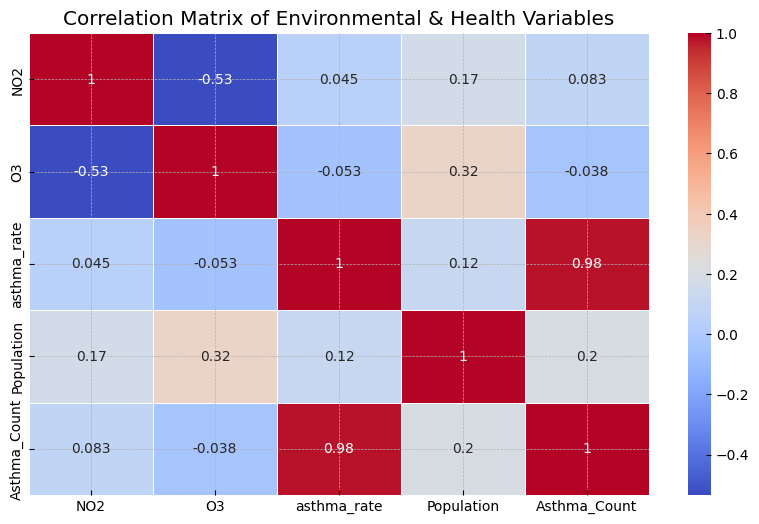

In [77]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Environmental & Health Variables")
plt.show()

Interpretation of Correlation Matrix

The correlation matrix shows several key relationships among environmental and health variables.
First, asthma_rate and Asthma_Count have a very strong positive correlation (0.98). This is expected because asthma_rate is directly derived from the number of asthma cases in each neighborhood.

NO2 and O3 exhibit a moderate negative correlation (-0.53), indicating that areas with higher NO2 levels tend to have lower O3 concentrations, which aligns with known atmospheric chemistry interactions.

Both air pollution variables (NO2 and O3) show very weak correlations with asthma_rate (around 0.04 and –0.05), suggesting that within this dataset, air pollutant levels may not be the primary drivers of asthma incidence. Population size shows only minor correlation with asthma_rate (0.12), meaning that variations in population do not strongly influence asthma risk after normalization.

Overall, the correlation matrix indicates no strong statistical relationship between NO2/O3 and asthma outcomes in this dataset.

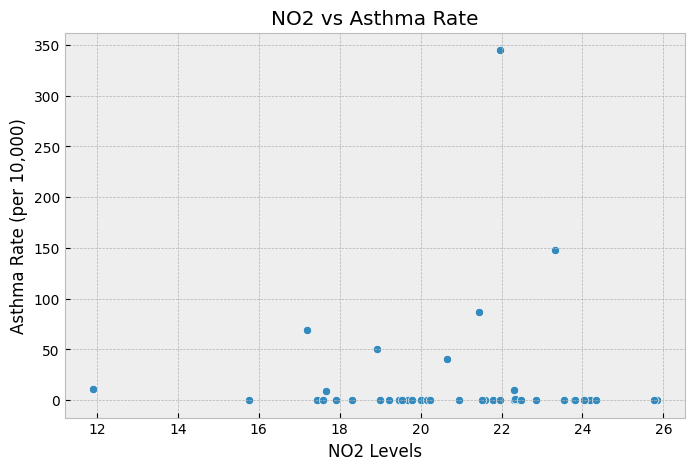

In [78]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="NO2", y="asthma_rate")
plt.title("NO2 vs Asthma Rate")
plt.xlabel("NO2 Levels")
plt.ylabel("Asthma Rate (per 10,000)")
plt.show()

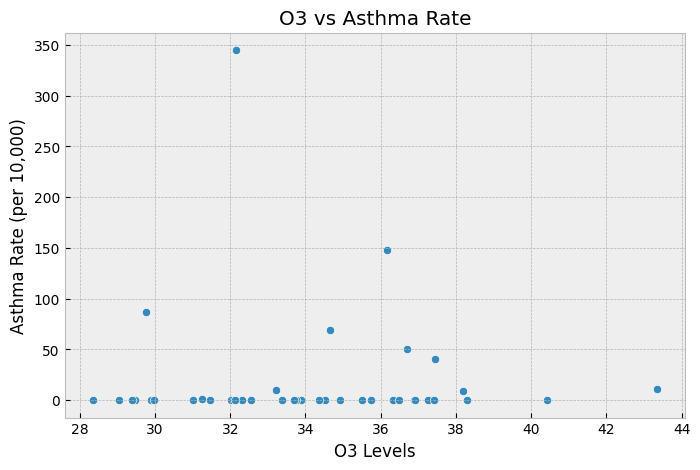

In [79]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="O3", y="asthma_rate")
plt.title("O3 vs Asthma Rate")
plt.xlabel("O3 Levels")
plt.ylabel("Asthma Rate (per 10,000)")
plt.show()

Interpretation of Key Patterns (NO2/O3 vs Asthma Rate)

The scatter plots for NO2 vs asthma_rate and O3 vs asthma_rate reveal no clear upward or downward trend. Most neighborhoods cluster around low asthma rates regardless of pollutant concentration. A few outliers with extremely high asthma rates create visual spikes, but these are isolated and do not reflect a general pattern.

This further supports the correlation matrix results:
NO2 and O3 levels are not strong predictors of asthma rates in this dataset.

Instead, the unusually high asthma rates appear driven by specific neighborhoods (e.g., “Unknown” areas), suggesting that other socio-environmental factors—such as housing conditions, healthcare access, smoking prevalence, or socioeconomic status—may play a larger role in asthma outcomes than air pollutants alone.

# Create Visualizations

/tmp/ipykernel_22534/1485622566.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=borough_summary, x="Borough", y="asthma_rate", palette="viridis")


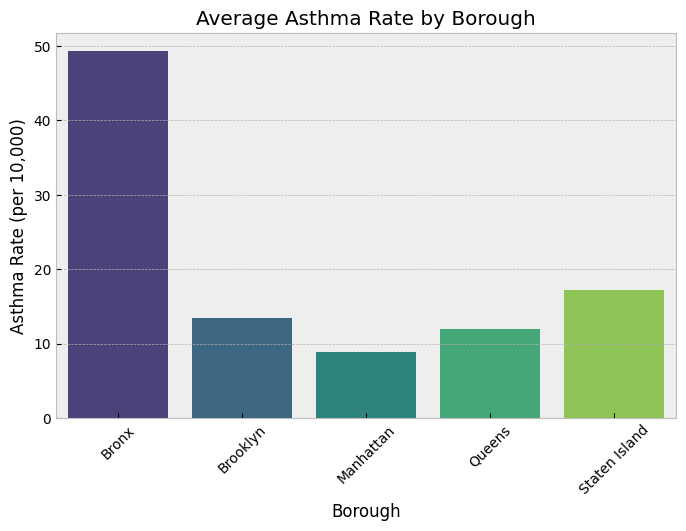

In [80]:
# Visualization A — Bar Chart of Asthma Rate by Borough

plt.figure(figsize=(8,5))
sns.barplot(data=borough_summary, x="Borough", y="asthma_rate", palette="viridis")
plt.title("Average Asthma Rate by Borough")
plt.ylabel("Asthma Rate (per 10,000)")
plt.xlabel("Borough")
plt.xticks(rotation=45)
p = os.path.join(output_path, "rate_by_boro.png")
plt.savefig(p, dpi=300, bbox_inches="tight")
plt.show()

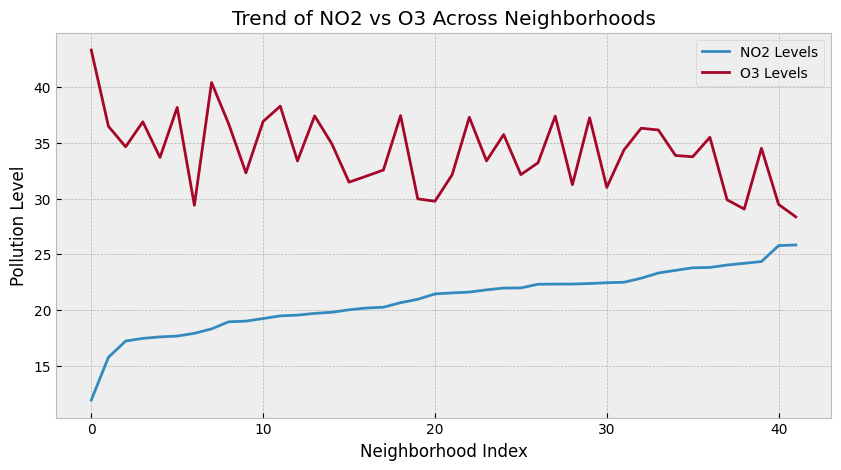

In [81]:
# Visualization B — Line Plot of NO2 & O3 Levels
df_sorted = df.sort_values("NO2")

plt.figure(figsize=(10,5))
plt.plot(df_sorted["NO2"].values, label="NO2 Levels")
plt.plot(df_sorted["O3"].values, label="O3 Levels")
plt.title("Trend of NO2 vs O3 Across Neighborhoods")
plt.xlabel("Neighborhood Index")
plt.ylabel("Pollution Level")
plt.legend()
plt.show()

# Top 10 Neighborhoods

In [82]:
# Get top 10 neighborhoods by asthma_rate
top10 = neighborhood_summary.sort_values("asthma_rate", ascending=False).head(10)


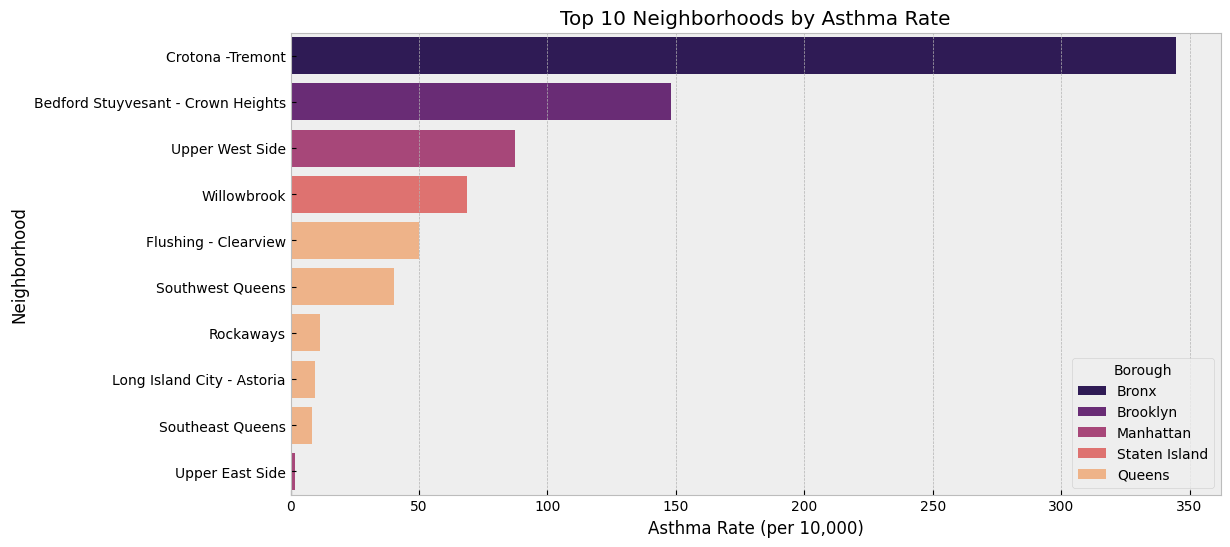

In [83]:
# Visualization: Bar Chart of Top 10 Neighborhoods
plt.figure(figsize=(12,6))
sns.barplot(data=top10,
            x="asthma_rate",
            y="Geo Place Name",
            hue="Borough",
            palette="magma")

plt.title("Top 10 Neighborhoods by Asthma Rate")
plt.xlabel("Asthma Rate (per 10,000)")
plt.ylabel("Neighborhood")
plt.legend(title="Borough")
p = os.path.join(output_path, "top10_asthma_rate.png")
plt.savefig(p, dpi=300, bbox_inches="tight")
plt.show()

# Geospatial Visualizations

## Setup

In [84]:
%pip install geopandas
import geopandas as gpd
import matplotlib.patches as mpatches

Note: you may need to restart the kernel to use updated packages.


In [85]:
geojson_file = "nyc-zip-code-tabulation-areas-polygons.geojson"
geojson_path = os.path.join(resources_path, geojson_file)
n_quantiles = 3

# Color palettes for bivariate maps
bivariate_colors = {
    "0-0": "#e8e8e8",
    "0-1": "#b0d5df",
    "0-2": "#64acbe",
    "1-0": "#e4acac",
    "1-1": "#ad9ea5",
    "1-2": "#627f8c",
    "2-0": "#c85a5a",
    "2-1": "#985356",
    "2-2": "#574249",
}

In [86]:
# Define the mapping between ZIP3 and UHF42
# Many-to-many mapping between ZIP3 and UHF42.
uhf_to_zip3_map_data = """UHF42,zip3
101,104
102,104
103,104
104,104
105,104
106,104
107,104
201,112
202,111
203,111
204,112
205,112
206,111
207,111
208,112
209,111
210,111
211,112
301,100
302,100
303,100
304,100
305,101
306,100
307,100
308,100
309,100
310,102
401,111
402,113
403,113
404,113
405,113
406,113
407,114
408,114
409,110
410,116
501,103
502,103
503,103
504,103
"""

## Geo functions

These functions set up both a dataframe with the appropriate merges, as well as the GeoJSON data files that are necessary for displaying map data with GeoPandas and MatPlotLib.

In [87]:
def prepare_data(asthma_pd, final_df, uhf_zip_map_csv):
    """Loads and processes the data to create a merged ZIP3-level DataFrame."""
    print("--- Preparing Data ---")

    zip3_map = pd.read_csv(StringIO(uhf_zip_map_csv))
    zip3_map["zip3"] = zip3_map["zip3"].astype(str)

    uhf_data_with_zip3 = pd.merge(final_df, zip3_map, on="UHF42")
    aggregated_uhf_data = (
        uhf_data_with_zip3.groupby("zip3")
        .agg(
            NO2_avg=("NO2", "mean"),
            O3_avg=("O3", "mean"),
            Population_sum=("Population", "sum"),
        )
        .reset_index()
    )

    geo_df = pd.merge(asthma_pd, aggregated_uhf_data, on="zip3", how="left")

    print("\nData preparation complete.")
    return geo_df


def prepare_geospatial_data(geojson_path, data_df):
    """Loads geospatial data and merges it with the processed DataFrame."""
    print("\n--- Preparing Geospatial Data ---")
    try:
        nyc_zcta_gdf = gpd.read_file(geojson_path)
    except Exception as e:
        print(f"Could not load geospatial data from {geojson_path}. Error: {e}")
        return None

    print("Creating ZIP3 boundaries...")
    nyc_zcta_gdf["zip3"] = nyc_zcta_gdf["postalCode"].str[:3]

    # Merge data first
    merged_gdf = nyc_zcta_gdf.merge(data_df, on="zip3", how="left")

    return merged_gdf

These functions generically plot either single or bivariate geospatial maps, displaying the data over their associated locations in the city of New York. 

In [88]:
def plot_choropleth(gdf, column, title, output_path, cmap="plasma", legend_label=""):
    """Generates and saves a single-variable choropleth map."""
    print(f"Generating choropleth map for '{column}'...")
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap,
        missing_kwds={"color": "lightgrey"},
        legend_kwds={"label": legend_label, "orientation": "horizontal"},
    )
    ax.set_title(title, fontdict={"fontsize": "16", "fontweight": "3"})
    ax.axis("off")

    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"Saved map to {output_path}")

In [89]:
def plot_bivariate_map(
	gdf, var1_col, var2_col, var1_label, var2_label, colors, title, output_path
):
	"""Generates and saves a bivariate choropleth map."""
	print(f"--- Starting Bivariate Choropleth ( {var1_label} vs {var2_label} ) ---")

	bivariate_gdf = gdf.dropna(subset=[var1_col, var2_col]).copy()
	if bivariate_gdf.empty:
		print(f"No data to plot for {title}. Skipping.")
		return

	# Classify data
	try:
		var1_quantiles = pd.qcut(
			bivariate_gdf[var1_col],
			n_quantiles,
			labels=range(n_quantiles),
			duplicates="drop",
		)
		var2_quantiles = pd.qcut(
			bivariate_gdf[var2_col],
			n_quantiles,
			labels=range(n_quantiles),
			duplicates="drop",
		)
	except ValueError as e:
		print(
			f"Could not classify data for bivariate map '{title}'. Error: {e}. Skipping."
		)
		return

	bivariate_gdf["bivariate_class"] = (
		var1_quantiles.astype(str) + "-" + var2_quantiles.astype(str)
	)
	bivariate_gdf["color"] = bivariate_gdf["bivariate_class"].map(colors)

	# Plot map
	fig, ax = plt.subplots(1, 1, figsize=(12, 12))
	bivariate_gdf.plot(
		color=bivariate_gdf["color"], ax=ax, edgecolor="white", linewidth=0.5
	)

	# Create legend
	legend_ax = fig.add_axes([0.05, 0.75, 0.2, 0.2], zorder=5)
	legend_ax.set_xticks([])
	legend_ax.set_yticks([])
	legend_ax.set_facecolor("#f0f0f0")
	legend_ax.spines[:].set_visible(False)

	for i in range(n_quantiles):
		for j in range(n_quantiles):
			color = colors.get(f"{i}-{j}")
			if color:
				rect = mpatches.Rectangle(
					(j / n_quantiles, i / n_quantiles),
					1 / n_quantiles,
					1 / n_quantiles,
					facecolor=color,
					edgecolor="black",
					linewidth=0.5,
				)
				legend_ax.add_patch(rect)

	legend_ax.text(
		0.5,
		1.05,
		f"High {var2_label} →",
		transform=legend_ax.transAxes,
		ha="center",
		va="bottom",
		fontsize=10,
	)
	legend_ax.text(
		-0.05,
		0.5,
		f"High {var1_label} →",
		transform=legend_ax.transAxes,
		ha="right",
		va="center",
		fontsize=10,
		rotation=90,
	)

	# Finalize and save
	ax.set_title(title, fontdict={"fontsize": "18", "fontweight": "3"})
	ax.axis("off")
	plt.savefig(output_path, dpi=300, bbox_inches="tight")
	print(f"Saved map to {output_path}")

## Generate Views

In [90]:
prepped_df = prepare_data(asthma_pd, final_df, uhf_to_zip3_map_data)
map_gdf = prepare_geospatial_data(geojson_path, prepped_df)
bivariate_df = map_gdf.drop_duplicates(subset=["zip3"])

plt.style.use("bmh")

--- Preparing Data ---

Data preparation complete.

--- Preparing Geospatial Data ---
Creating ZIP3 boundaries...


### Plot Asthma

Generating choropleth map for 'Asthma_Count'...
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_zip3_asthma_count.png


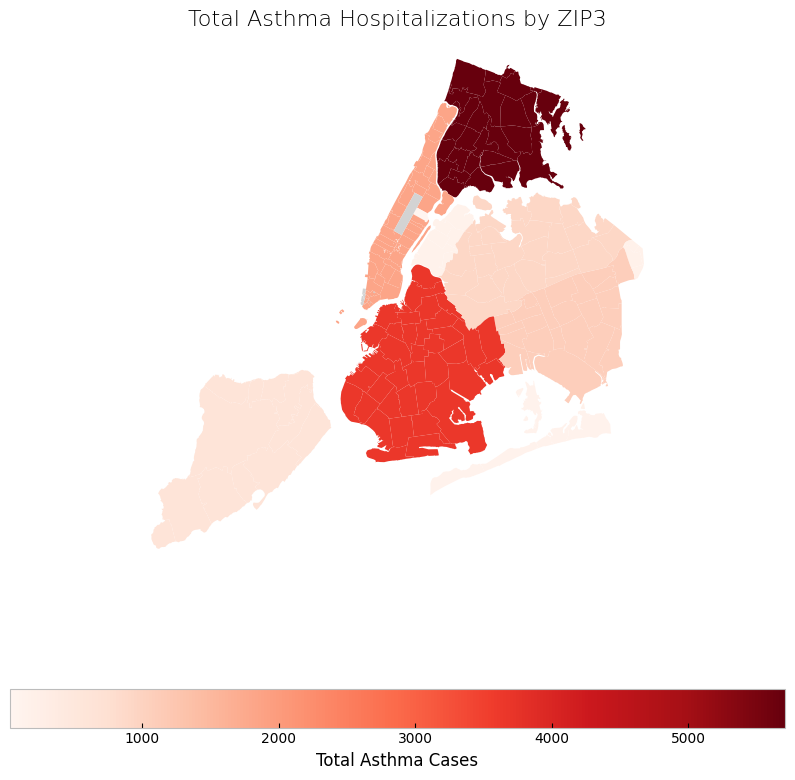

In [91]:
plot_choropleth(
    map_gdf,
    "Asthma_Count",
    "Total Asthma Hospitalizations by ZIP3",
    os.path.join(output_path, "map_zip3_asthma_count.png"),
    cmap="Reds",
    legend_label="Total Asthma Cases",
)

### Plot NO2

Generating choropleth map for 'NO2_avg'...
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_zip3_no2.png


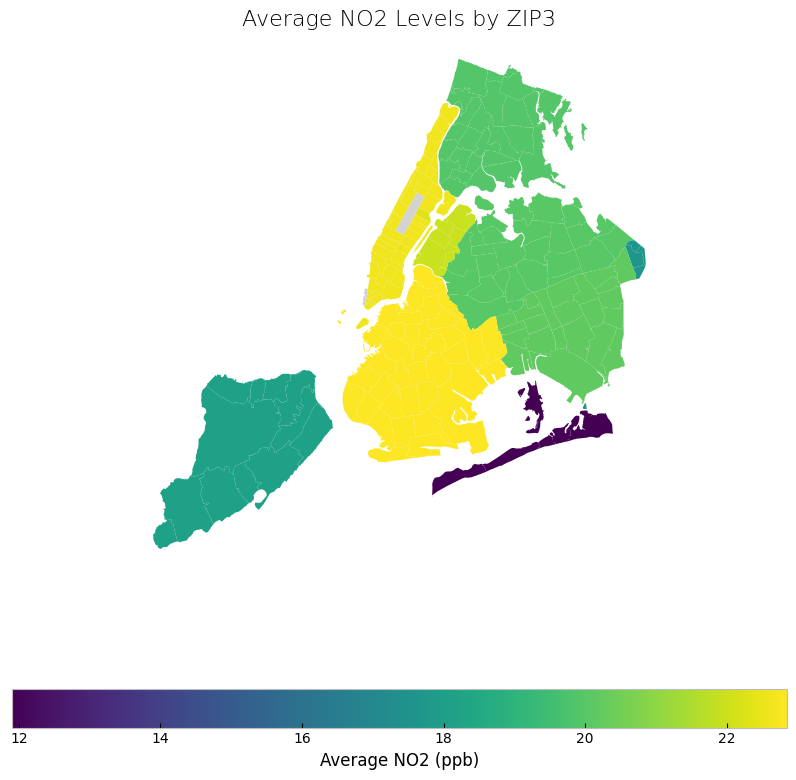

In [92]:
plot_choropleth(
    map_gdf,
    "NO2_avg",
    "Average NO2 Levels by ZIP3",
    os.path.join(output_path, "map_zip3_no2.png"),
    cmap="viridis",
    legend_label="Average NO2 (ppb)",
)

### Plot O3

Generating choropleth map for 'O3_avg'...
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_zip3_o3.png


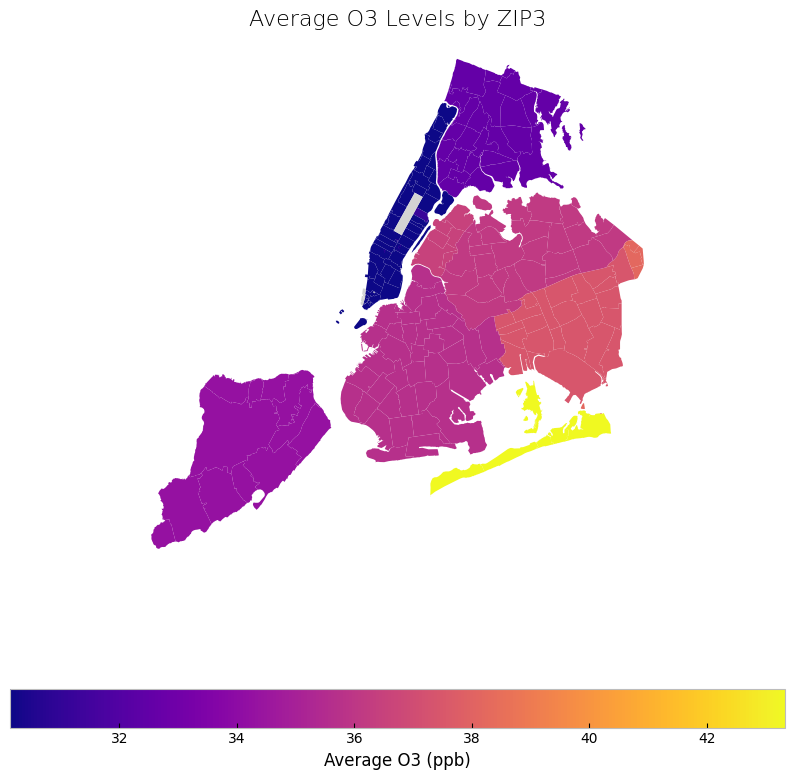

In [93]:
plot_choropleth(
    map_gdf,
    "O3_avg",
    "Average O3 Levels by ZIP3",
    os.path.join(output_path, "map_zip3_o3.png"),
    cmap="plasma",
    legend_label="Average O3 (ppb)",
)

## Bivariate Visualizations

### Asthma vs. NO2

--- Starting Bivariate Choropleth ( Asthma vs NO2 ) ---
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_zip3_bivariate_asthma_no2.png


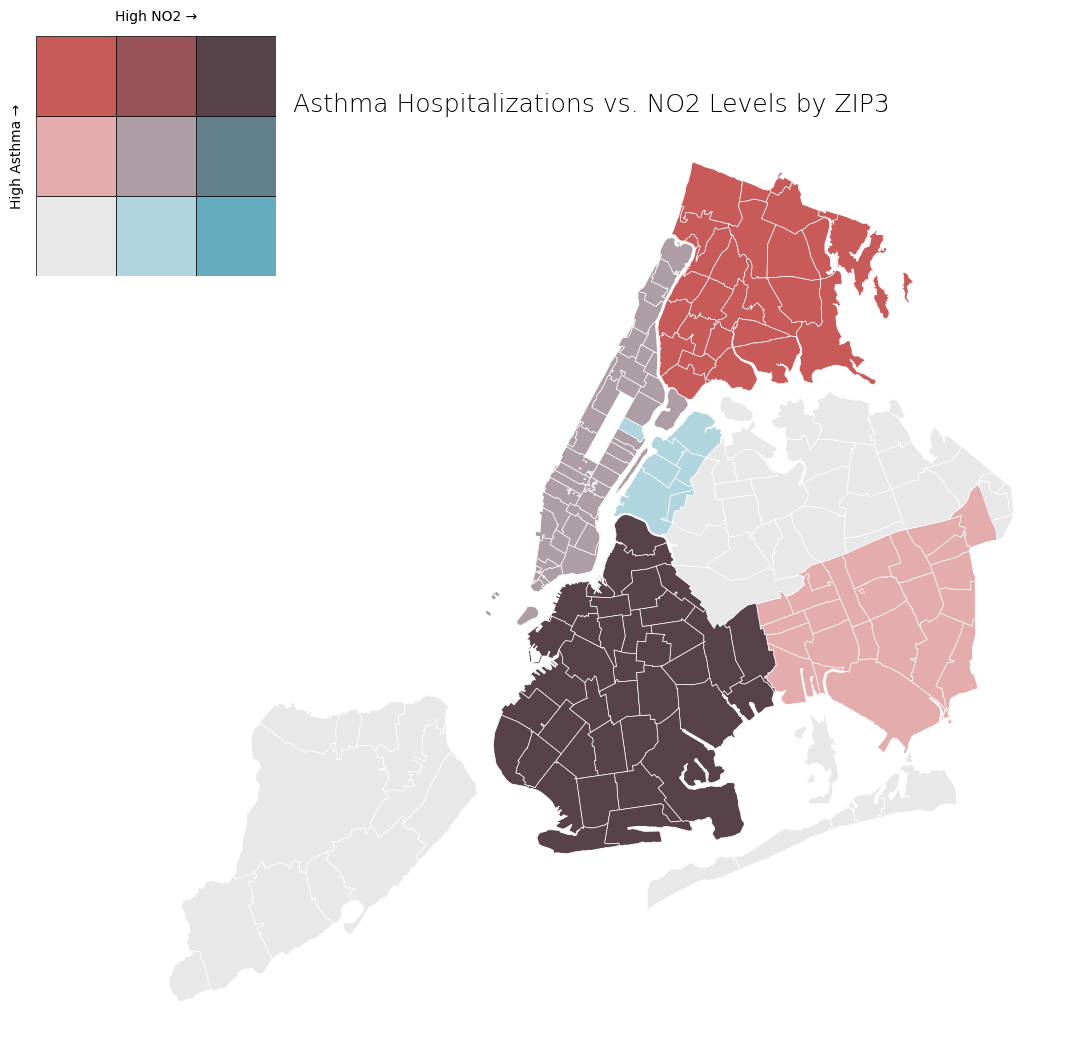

In [94]:
plot_bivariate_map(
    map_gdf,
    "Asthma_Count",
    "NO2_avg",
    "Asthma",
    "NO2",
    bivariate_colors,
    "Asthma Hospitalizations vs. NO2 Levels by ZIP3",
    os.path.join(output_path, "map_zip3_bivariate_asthma_no2.png"),
)

### Asthma vs O3

--- Starting Bivariate Choropleth ( Asthma vs O3 ) ---
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_zip3_bivariate_asthma_o3.png


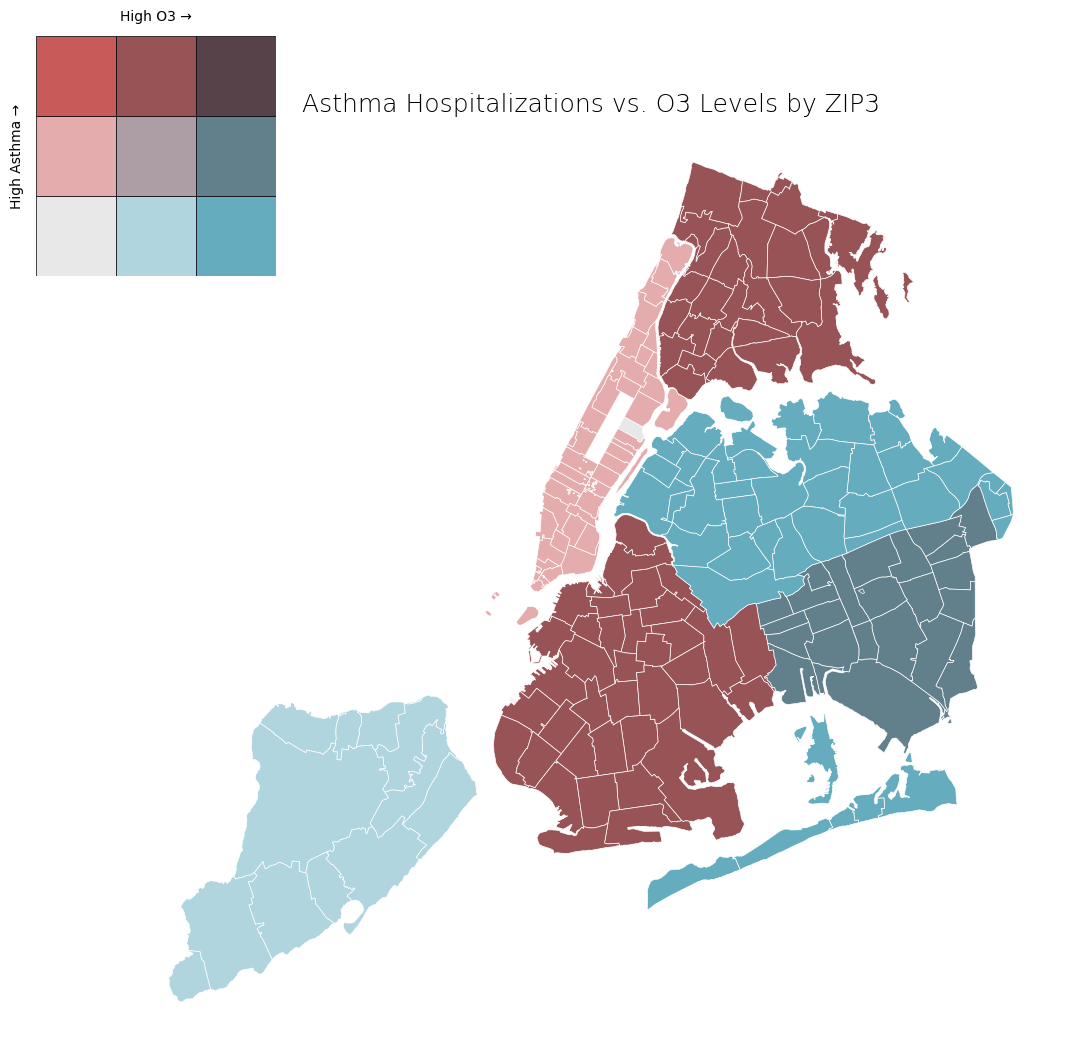

In [95]:
plot_bivariate_map(
    map_gdf,
    "Asthma_Count",
    "O3_avg",
    "Asthma",
    "O3",
    bivariate_colors,
    "Asthma Hospitalizations vs. O3 Levels by ZIP3",
    os.path.join(output_path, "map_zip3_bivariate_asthma_o3.png"),
)

## Boroughs

This code closely resembles the above code, which uses zip3's as the geographical basis, but instead uses New York City's boroughs to display data. 

In [96]:
geojson_borough_file = "boroughs.geojson"
n_quantiles = 2

bivariate_colors = {
    "0-0": "#e8e8e8",
    "0-1": "#b0d5df",
    "1-0": "#e4acac",
    "1-1": "#ad9ea5",
}

In [97]:
def get_borough_from_uhf(uhf):
    """Maps UHF42 code to a borough name."""
    uhf = int(uhf)
    if 101 <= uhf <= 107:
        return "Bronx"
    elif 201 <= uhf <= 211:
        return "Brooklyn"
    elif 301 <= uhf <= 310:
        return "Manhattan"
    elif 401 <= uhf <= 410:
        return "Queens"
    elif 501 <= uhf <= 504:
        return "Staten Island"
    else:
        return "Unknown"

def prepare_borough_data(csv_path):
    """Loads and aggregates data to the borough level."""
    print("--- Preparing Borough Data ---")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Dataset not found at {csv_path}. Please run the main notebook to generate it.")

    df = pd.read_csv(csv_path)

    # Clean data
    df["Asthma_Count"] = df["Asthma_Count"].fillna(0)
    df = df.dropna(subset=["UHF42", "Population", "NO2", "O3"])

    # Map UHF42 to Borough
    df["Borough"] = df["UHF42"].apply(get_borough_from_uhf)
    df = df[df["Borough"] != "Unknown"]

    # Aggregate data by borough
    borough_summary = df.groupby("Borough").agg(
        NO2_avg=("NO2", "mean"),
        O3_avg=("O3", "mean"),
        Population_sum=("Population", "sum"),
        Asthma_Count_sum=("Asthma_Count", "sum")
    ).reset_index()

    # Calculate asthma rate per 10,000
    borough_summary["asthma_rate"] = (borough_summary["Asthma_Count_sum"] / borough_summary["Population_sum"]) * 10000

    print("Borough data preparation complete.")
    print(borough_summary)
    return borough_summary

def prepare_geospatial_data(geojson_path, data_df):
    """Loads geospatial data and merges it with the processed borough DataFrame."""
    print("\n--- Preparing Geospatial Data for Boroughs ---")
    try:
        borough_gdf = gpd.read_file(geojson_path)
    except Exception as e:
        print(f"Could not load geospatial data from {geojson_path}. Error: {e}")
        return None

    # Merge data
    # The geojson uses 'name' for the borough name
    merged_gdf = borough_gdf.merge(data_df, left_on="name", right_on="Borough", how="left")

    return merged_gdf

def plot_choropleth(gdf, column, title, output_path, cmap="plasma", legend_label=""):
    """Generates and saves a single-variable choropleth map."""
    print(f"Generating choropleth map for '{column}'...")
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap,
        missing_kwds={"color": "lightgrey"},
        legend_kwds={"label": legend_label, "orientation": "horizontal"},
    )
    ax.set_title(title, fontdict={"fontsize": "16", "fontweight": "3"})
    ax.set_axis_off()

    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"Saved map to {output_path}")

In [98]:
def plot_bivariate_map(
    gdf, var1_col, var2_col, var1_label, var2_label, colors, title, output_path
):
    """Generates and saves a bivariate choropleth map."""
    print(f"--- Starting Bivariate Choropleth ( {var1_label} vs {var2_label} ) ---")

    bivariate_gdf = gdf.dropna(subset=[var1_col, var2_col]).copy()
    if bivariate_gdf.empty:
        print(f"No data to plot for {title}. Skipping.")
        return

    # Classify data
    try:
        var1_quantiles = pd.qcut(
            bivariate_gdf[var1_col],
            n_quantiles,
            labels=range(n_quantiles),
            duplicates="drop",
        )
        var2_quantiles = pd.qcut(
            bivariate_gdf[var2_col],
            n_quantiles,
            labels=range(n_quantiles),
            duplicates="drop",
        )
    except ValueError as e:
        print(
            f"Could not classify data for bivariate map '{title}'. Error: {e}. Skipping."
        )
        return

    bivariate_gdf["bivariate_class"] = (
        var1_quantiles.astype(str) + "-" + var2_quantiles.astype(str)
    )
    bivariate_gdf["color"] = bivariate_gdf["bivariate_class"].map(colors)

    # Plot map
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    bivariate_gdf.plot(
        color=bivariate_gdf["color"], ax=ax, edgecolor="white", linewidth=0.5
    )

    # Create legend
    legend_ax = fig.add_axes([0.05, 0.75, 0.2, 0.2], zorder=5)
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    legend_ax.set_facecolor("#f0f0f0")
    legend_ax.spines[:].set_visible(False)

    for i in range(n_quantiles):
        for j in range(n_quantiles):
            color = colors.get(f"{i}-{j}")
            if color:
                rect = mpatches.Rectangle(
                    (j / n_quantiles, i / n_quantiles),
                    1 / n_quantiles,
                    1 / n_quantiles,
                    facecolor=color,
                    edgecolor="black",
                    linewidth=0.5,
                )
                legend_ax.add_patch(rect)

    legend_ax.text(
        0.5,
        1.05,
        f"High {var2_label} →",
        transform=legend_ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=10,
    )
    legend_ax.text(
        -0.05,
        0.5,
        f"High {var1_label} →",
        transform=legend_ax.transAxes,
        ha="right",
        va="center",
        fontsize=10,
        rotation=90,
    )

    # Finalize and save
    ax.set_title(title, fontdict={"fontsize": "18", "fontweight": "3"})
    ax.axis("off")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"Saved map to {output_path}")

Generating choropleth map for 'Asthma_Count'...
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_borough_asthma_rate.png
Generating choropleth map for 'NO2_avg'...
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_borough_no2.png
Generating choropleth map for 'O3_avg'...
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_borough_o3.png


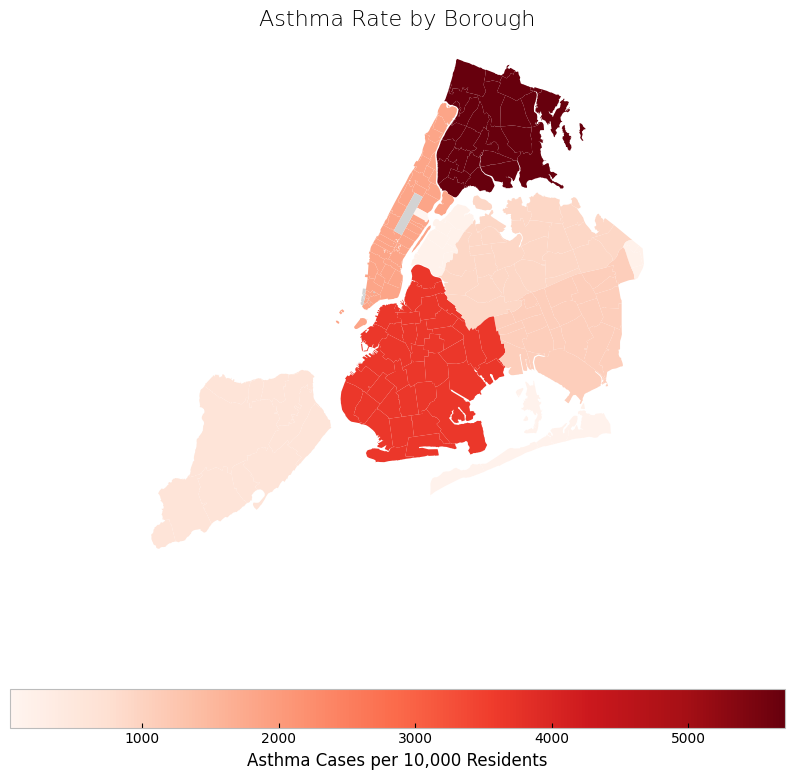

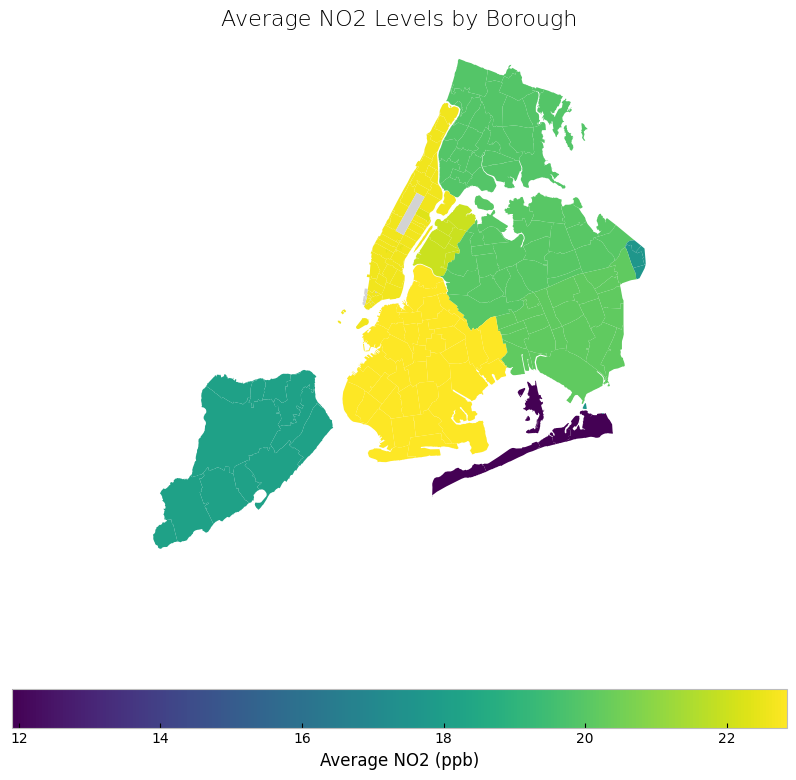

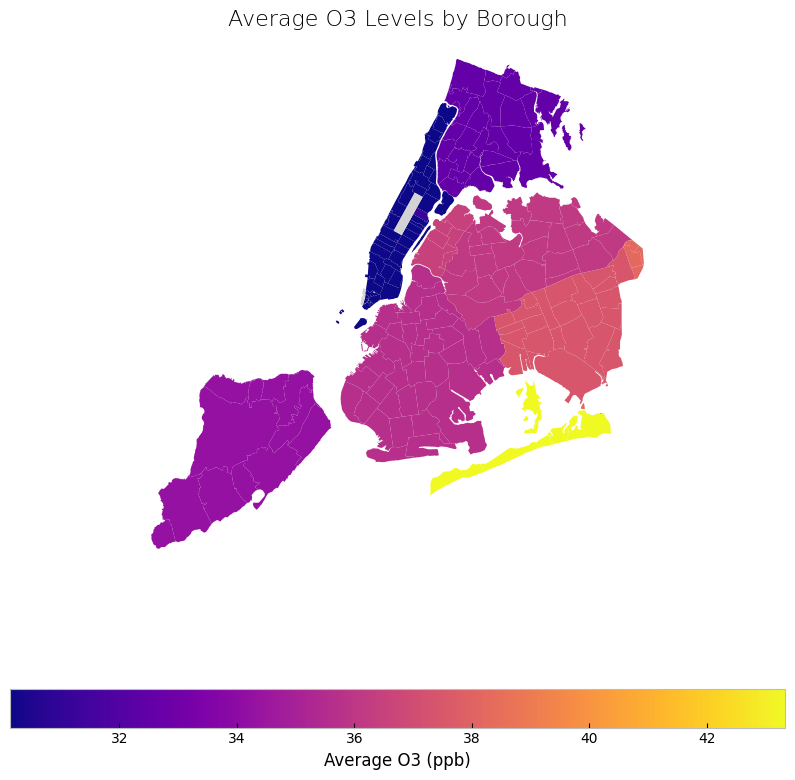

In [99]:
# 1. Asthma Rate Map
plot_choropleth(
    map_gdf,
    "Asthma_Count",
    "Asthma Rate by Borough",
    os.path.join(output_path, "map_borough_asthma_rate.png"),
    cmap="Reds",
    legend_label="Asthma Cases per 10,000 Residents",
)

# 2. NO2 Map
plot_choropleth(
    map_gdf,
    "NO2_avg",
    "Average NO2 Levels by Borough",
    os.path.join(output_path, "map_borough_no2.png"),
    cmap="viridis",
    legend_label="Average NO2 (ppb)",
)

# 3. O3 Map
plot_choropleth(
    map_gdf,
    "O3_avg",
    "Average O3 Levels by Borough",
    os.path.join(output_path, "map_borough_o3.png"),
    cmap="plasma",
    legend_label="Average O3 (ppb)",
)


--- Starting Bivariate Choropleth ( Asthma Rate vs NO2 ) ---
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_borough_bivariate_asthma_no2.png
--- Starting Bivariate Choropleth ( Asthma Rate vs O3 ) ---
Saved map to /home/philip/uni/big_data/BigDataProject/output/map_borough_bivariate_asthma_o3.png


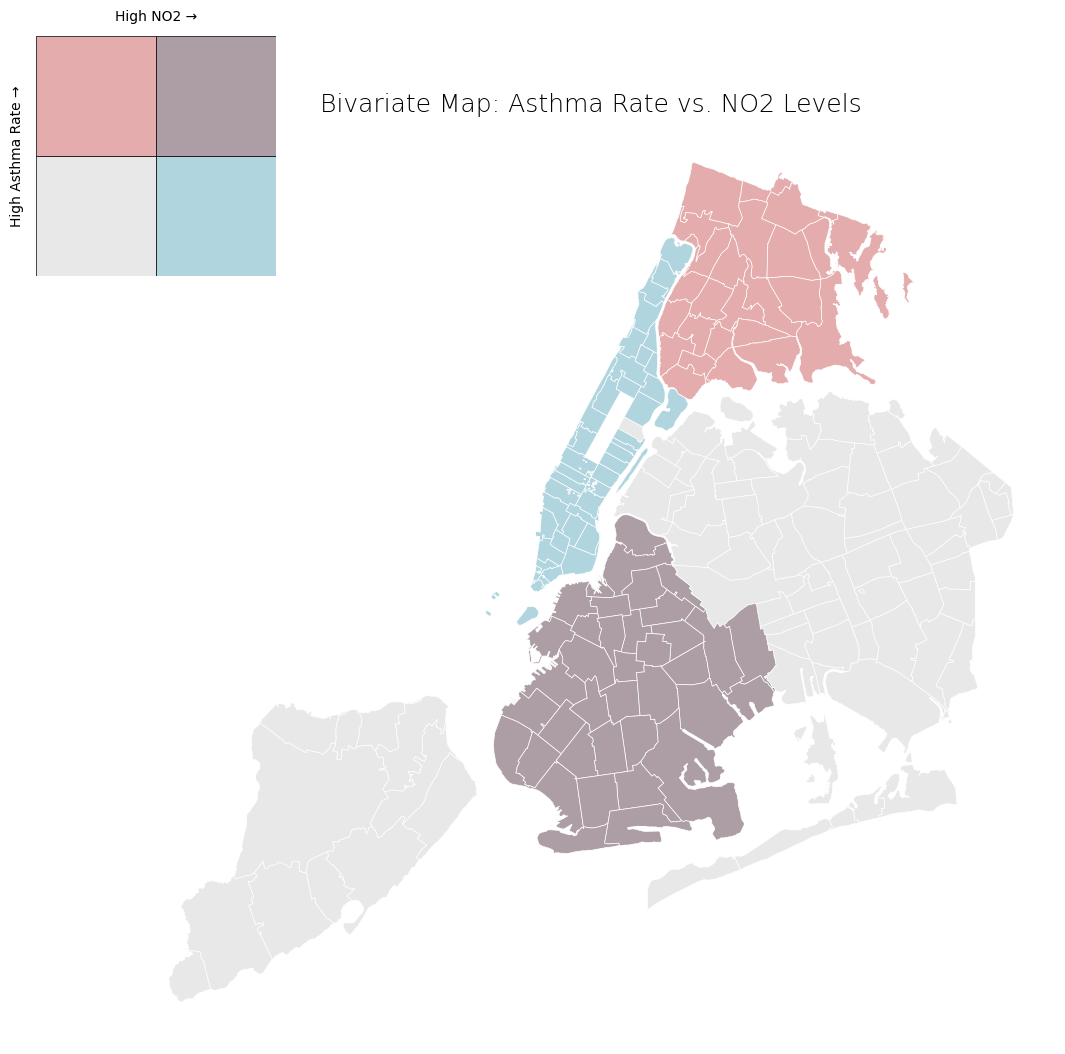

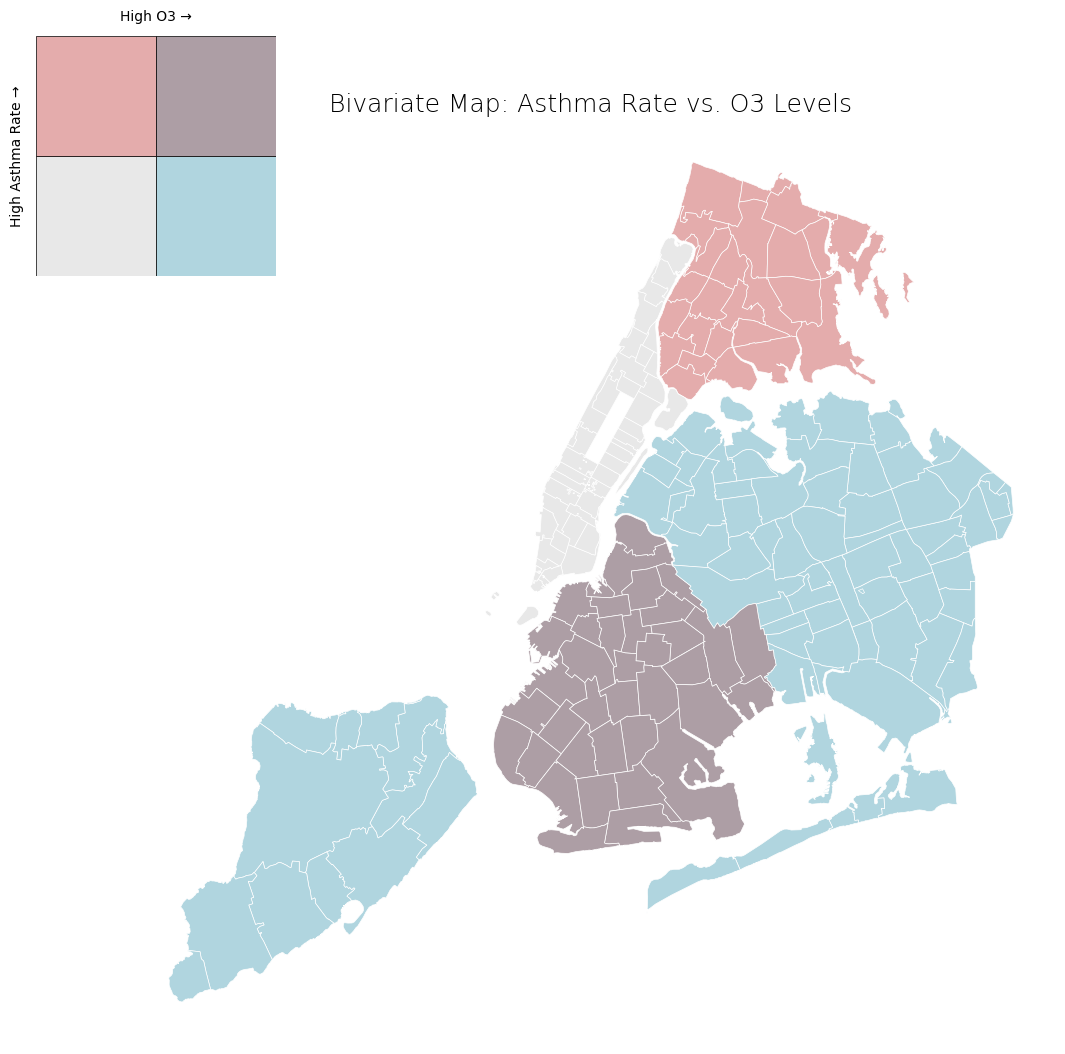

In [100]:
plot_bivariate_map(
    map_gdf,
    "Asthma_Count",
    "NO2_avg",
    "Asthma Rate",
    "NO2",
    bivariate_colors,
    "Bivariate Map: Asthma Rate vs. NO2 Levels",
    os.path.join(output_path, "map_borough_bivariate_asthma_no2.png"),
)

plot_bivariate_map(
    map_gdf,
    "Asthma_Count",
    "O3_avg",
    "Asthma Rate",
    "O3",
    bivariate_colors,
    "Bivariate Map: Asthma Rate vs. O3 Levels",
    os.path.join(output_path, "map_borough_bivariate_asthma_o3.png"),
)

# Short interpretation of results

The analysis shows that air pollutants such as NO2 and O3 have only very weak correlations with asthma rates across New York City neighborhoods, suggesting that pollution levels alone do not fully explain the distribution of asthma outcomes. Population size demonstrates a moderate positive correlation with total asthma cases, meaning that more densely populated areas naturally report higher numbers of cases. Among the pollutants studied, NO2 exhibits the strongest—though still minimal—association with asthma rate, while O3 shows almost no meaningful relationship. Neighborhood comparisons reveal substantial variation in asthma risk, with Crotona–Tremont, Bedford Stuyvesant–Crown Heights, and the Upper West Side emerging as the highest-risk areas. Overall, the findings indicate that asthma rates are influenced by factors beyond measured pollution levels and that certain neighborhoods, particularly within the Bronx, Brooklyn, and Queens, experience disproportionately elevated asthma burdens.

# Note which pollutants correlate most

Based on the correlation analysis, NO₂ shows the highest correlation with asthma rates among the pollutants analyzed, although the relationship is extremely weak and not clinically meaningful. O₃ displays an even weaker and slightly negative correlation with asthma outcomes. Overall, the data suggests that air pollution levels, as measured here, do not strongly predict asthma risk across neighborhoods

# Identify high-risk neighborhoods

The analysis identifies several neighborhoods with significantly elevated asthma rates. Crotona–Tremont shows the highest asthma burden, with more than double the rate observed in other high-risk areas. Bedford Stuyvesant–Crown Heights and the Upper West Side also exhibit notably elevated asthma rates, indicating persistent respiratory health challenges. These neighborhoods should be prioritized for targeted public health interventions and environmental risk mitigation.